In [1]:
import numpy as np
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
g_datafolder = '/development/data'
g_customer_dataset = '{}/olist_customers_dataset.csv'.format(g_datafolder)
g_orders_dataset = '{}/olist_orders_dataset.csv'.format(g_datafolder)
g_payments_dataset = '{}/olist_order_payments_dataset.csv'.format(g_datafolder)
g_orderitems_dataset = '{}/olist_order_items_dataset.csv'.format(g_datafolder)


In [3]:
def load_dataset(datafile, parse_dates=None):
    df = pd.read_csv(datafile, delimiter=',', parse_dates=parse_dates)
    return df

In [4]:
customer_df = load_dataset(g_customer_dataset)
parse_dates = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_df = load_dataset(g_orders_dataset, parse_dates=parse_dates)
payments_df = load_dataset(g_payments_dataset)
orderitems_df = load_dataset(g_orderitems_dataset)
cust_ord_df = orders_df.set_index('customer_id').join(customer_df.set_index('customer_id'), how="inner").reset_index()
cust_ord_df = cust_ord_df.set_index('order_id').join(orderitems_df.set_index('order_id'), how="inner").reset_index()
cust_ord_df['total_value'] = np.round(cust_ord_df['price'] + cust_ord_df['freight_value'], 0)

In [5]:
observation_period_end = cust_ord_df.order_purchase_timestamp.max()
calibration_period_end = datetime(2018,4,1)
data_df = calibration_and_holdout_data(cust_ord_df
                                    , customer_id_col='customer_unique_id'
                                    , datetime_col='order_purchase_timestamp'
                                    , calibration_period_end=calibration_period_end
                                    , observation_period_end=observation_period_end
                                    , monetary_value_col='total_value')

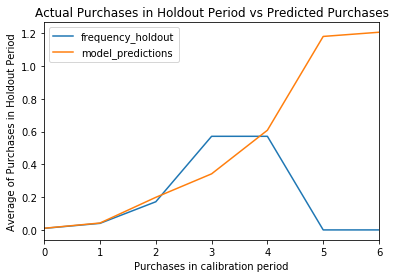

In [6]:
#Fader, Peter S., Bruce G.S. Hardie, and Ka Lok Lee (2005a), “Counting Your Customers the Easy Way: An Alternative to the Pareto/NBD Model,” Marketing Science, 24 (2), 275-84.   
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data_df['frequency_cal'], data_df['recency_cal'], data_df['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, data_df)

In [11]:
predicted_df = bgf.conditional_expected_number_of_purchases_up_to_time(t=155
                                                       ,frequency=data_df['frequency_cal']
                                                       ,recency=data_df['recency_cal']
                                                       ,T=data_df['T_cal'])
data_df['frequency_predicted'] = predicted_df

In [17]:
data_df[['frequency_cal', 'frequency_holdout', 'frequency_predicted']].groupby(['frequency_cal']).mean()

,frequency_holdout,frequency_predicted
frequency_cal,,
0.0,0.009553,0.010218
1.0,0.040109,0.042139
2.0,0.171875,0.198918
3.0,0.571429,0.342309
4.0,0.571429,0.608536
5.0,0.000000,1.181121
6.0,0.000000,1.206688
8.0,7.000000,0.355354


In [ ]:
data_df[['monetary_value_cal', 'frequency_cal']].corr()


In [ ]:
## Technically there is a high correlation between the monetary_value and frequency, so we should not use the GammaGamma model
## Below code is for demonstration purpose

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
data2_df = data_df[data_df.frequency_cal > 0.0]
ggf.fit(data2_df['frequency_cal'], data2_df['monetary_value_cal'])
profit_df = ggf.conditional_expected_average_profit(data2_df['frequency_cal'], data2_df['monetary_value_cal'])
clv_df = ggf.customer_lifetime_value(bgf, time=12
                                     ,frequency=data2_df['frequency_cal']
                                     ,recency=data2_df['recency_cal']
                                     ,T=data2_df['T_cal']
                                     ,monetary_value =data2_df['monetary_value_cal'])